# What Happened When Gradient is Almost Zero

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from functorch import hessian
from torch.nn.utils import _stateless

In [2]:
torch.manual_seed(1)

## Model

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Linear(1, 128)
        self.l2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

## Function

$$\frac{\sin{(5\pi x)}}{5\pi x}$$

In [4]:
x = torch.linspace(-1, 1, 300).unsqueeze(1)
y = (np.sin(5 * np.pi * x)) / (5 * np.pi * x)

Text(0.5, 1.0, 'Function 1')

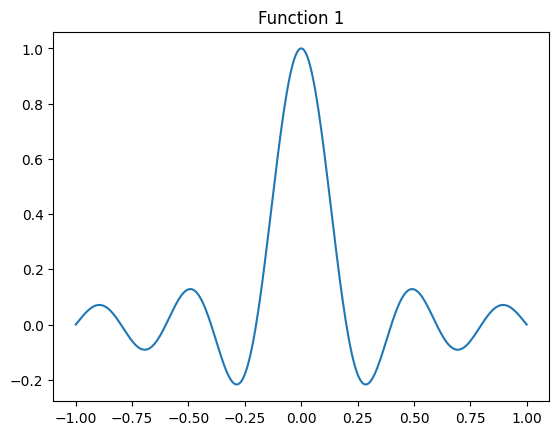

In [5]:
plt.plot(x, y)
plt.title("Function 1")

In [6]:
model = Model()
num_param = sum(p.numel() for p in model.parameters())
names = list(n for n, _ in model.named_parameters())

In [7]:
# Define loss function
def loss(params):
    y_hat = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, x)
    return ((y_hat - y) ** 2).mean()


# Calculate Hessian
hessian_func = hessian(loss)

In [14]:
def compute_gradient_norm(model):
    gradient_norm = 0
    for name, param in model.named_parameters():
        gradient_norm += torch.norm(param.grad, p=2) ** 2
    gradient_norm = torch.sqrt(gradient_norm)
    return gradient_norm.item()

In [15]:
model.train()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
training_loss = []
minimal_ratio = []
epochs = 100
for curr_epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(x)
    loss = loss_func(outputs, y)
    loss.backward()
    optimizer.step()

    H = hessian_func(tuple(model.parameters()))
    H = torch.cat([torch.cat([e.flatten() for e in Hpart]) for Hpart in H])  # flatten
    H = H.reshape(num_param, num_param)
    L, _ = torch.linalg.eigh(H)
    positive_eigenvalues = (L > 0).sum().float()
    minimal_ratio.append(positive_eigenvalues / L.numel())
    training_loss.append(loss.item())

    gradient_norm = compute_gradient_norm(model)
    print(gradient_norm)

    print(
        "Train Epoch: {}\tLoss: {:.6f}\tMinimal Ratio: {:.6f}".format(
            curr_epoch, loss.item(), minimal_ratio[-1]
        )
    )

    curr_epoch += 1

    if training_loss[-1] <= 1e-3:
        break

0.03050340712070465
Train Epoch: 0	Loss: 0.049320	Minimal Ratio: 0.498701
0.16722504794597626
Train Epoch: 1	Loss: 0.049380	Minimal Ratio: 0.498701
0.14894722402095795
Train Epoch: 2	Loss: 0.049132	Minimal Ratio: 0.498701
0.1390499770641327
Train Epoch: 3	Loss: 0.048940	Minimal Ratio: 0.498701
0.035178497433662415
Train Epoch: 4	Loss: 0.048631	Minimal Ratio: 0.498701
0.12613359093666077
Train Epoch: 5	Loss: 0.048613	Minimal Ratio: 0.498701
0.1173742264509201
Train Epoch: 6	Loss: 0.048432	Minimal Ratio: 0.498701
0.04116005823016167
Train Epoch: 7	Loss: 0.048157	Minimal Ratio: 0.498701
0.07365701347589493
Train Epoch: 8	Loss: 0.048024	Minimal Ratio: 0.498701
0.10574652999639511
Train Epoch: 9	Loss: 0.047912	Minimal Ratio: 0.498701
0.07171721011400223
Train Epoch: 10	Loss: 0.047699	Minimal Ratio: 0.498701
0.03332771360874176
Train Epoch: 11	Loss: 0.047504	Minimal Ratio: 0.498701
0.07466641813516617
Train Epoch: 12	Loss: 0.047382	Minimal Ratio: 0.498701
0.08338134735822678
Train Epoch: 13	

## Result

[]

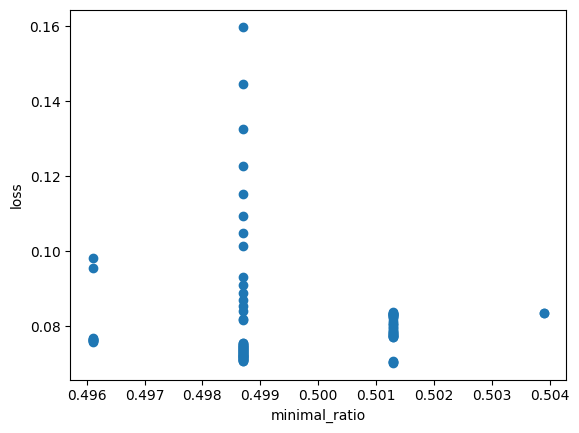

In [9]:
plt.scatter(minimal_ratio, training_loss)
plt.xlabel("minimal_ratio")
plt.ylabel("loss")
plt.plot()